<a href="https://colab.research.google.com/github/umeshtharukaofficial/Spam-Detector-Colab/blob/main/Spam_Email_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # For a simple neural network

# Download NLTK data (only needs to be run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4') # Open Multilingual Wordnet for WordNetLemmatizer

# Load the dataset
# This dataset is commonly available and small enough to load directly.
# It's a tab-separated file with no header.
try:
    df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
    print("Dataset loaded from local file.")
except FileNotFoundError:
    # If not found locally, try downloading from a URL
    print("Local file not found. Attempting to download from URL...")
    # Use -nc (no-clobber) to avoid re-downloading if the file already exists
    # Updated URL to a working one for SMSSpamCollection.txt
    !wget -nc https://raw.githubusercontent.com/justmarkham/DAT5/master/data/SMSSpamCollection.txt -O SMSSpamCollection
    df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
    print("Dataset downloaded and loaded.")

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nValue counts for 'label':")
print(df['label'].value_counts())

# Map 'ham' to 0 and 'spam' to 1 for numerical processing
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})
print("\nFirst 5 rows with encoded label:")
print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Local file not found. Attempting to download from URL...
--2025-06-03 10:11:30--  https://raw.githubusercontent.com/justmarkham/DAT5/master/data/SMSSpamCollection.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 477907 (467K) [text/plain]
Saving to: ‘SMSSpamCollection’

SMSSpamCollection   100%[===================>] 466.71K  2.56MB/s    in 0.2s    

2025-06-03 10:11:31 (2.56 MB/s) - ‘SMSSpamCollection’ saved [477907/477907]

Dataset downloaded and loaded.

First 5 rows of the dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c 

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Original vs. Processed Message Examples:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Processed: go jurong point crazy available bugis n great world la e buffet cine got amore wat

Original: Ok lar... Joking wif u oni...
Processed: ok lar joking wif u oni

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Processed: free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply

Original: U dun say so early hor... U c already then say...
Processed: u dun say early hor u c already say

Original: Nah I don't think he goes to usf, he lives around here though
Processed: nah think go usf life around though



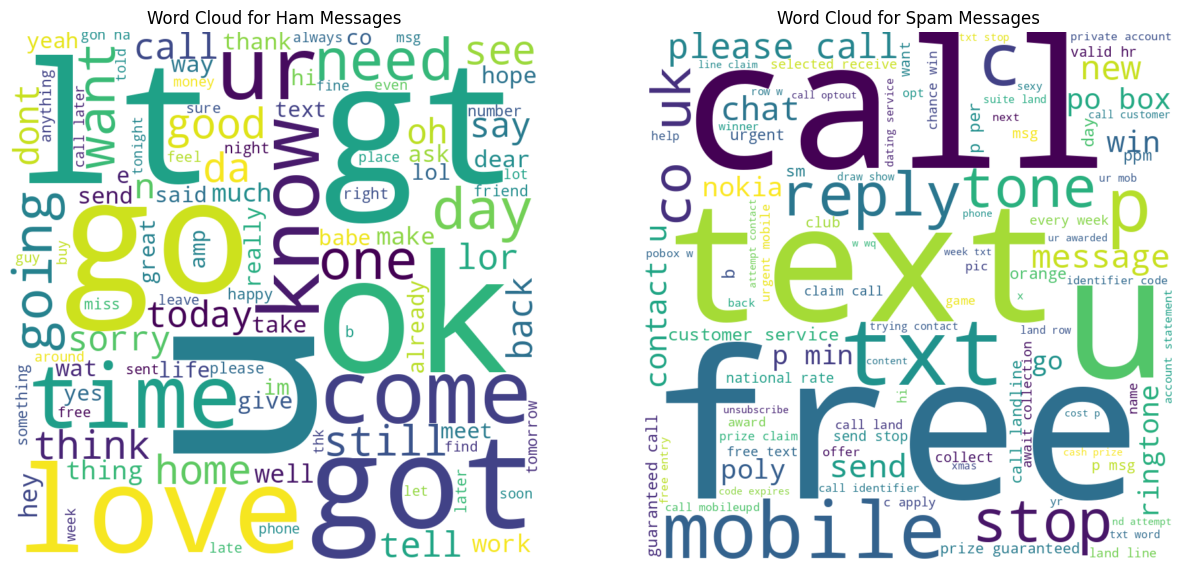

In [ ]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Download punkt_tab here to ensure it's available before tokenization
nltk.download('punkt_tab')

def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()
    # 2. Remove punctuation and numbers
    # Keep only letters and spaces, replacing others with a space to avoid concatenating words
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 3. Tokenization
    words = nltk.word_tokenize(text)
    # 4. Remove stop words and Lemmatize
    # Corrected: 'not in' instead of 'not_in'
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # 5. Join words back into a string
    text = ' '.join(words)
    return text

# Apply preprocessing to the 'message' column
df['processed_message'] = df['message'].apply(preprocess_text)

print("\nOriginal vs. Processed Message Examples:")
for i in range(5):
    print(f"Original: {df['message'].iloc[i]}")
    print(f"Processed: {df['processed_message'].iloc[i]}\n")

# Visualize word clouds for ham and spam (optional but insightful)
from wordcloud import WordCloud

ham_words = ' '.join(list(df[df['label'] == 'ham']['processed_message']))
spam_words = ' '.join(list(df[df['label'] == 'spam']['processed_message']))

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
ham_wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate(ham_words)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate(spam_words)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')

plt.show()

In [ ]:
# Split data into training and testing sets
X = df['processed_message']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} messages")
print(f"Testing set size: {X_test.shape[0]} messages")
print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Testing label distribution:\n{y_test.value_counts()}")

# Initialize TF-IDF Vectorizer
# max_features limits the number of features to the most frequent ones
# min_df ignores terms that appear in too few documents
# max_df ignores terms that appear in too many documents (e.g., common words not caught by stop words)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)

# Fit the vectorizer on the training data and transform both training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nShape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")


Training set size: 4457 messages
Testing set size: 1115 messages
Training label distribution:
label_encoded
0    3859
1     598
Name: count, dtype: int64
Testing label distribution:
label_encoded
0    966
1    149
Name: count, dtype: int64

Shape of X_train_tfidf: (4457, 1339)
Shape of X_test_tfidf: (1115, 1339)



--- Training Multinomial Naive Bayes ---
Multinomial Naive Bayes Performance:
Accuracy: 0.9740
Precision: 0.9688
Recall: 0.8322
F1-Score: 0.8953


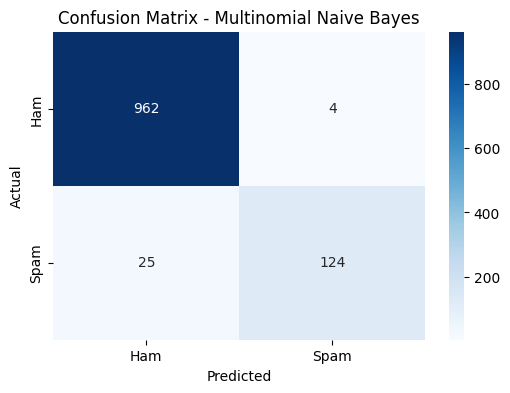

In [ ]:
print("\n--- Training Multinomial Naive Bayes ---")
mnb_model = MultinomialNB()
mnb_model.fit(X_train_tfidf, y_train)

y_pred_mnb = mnb_model.predict(X_test_tfidf)

print("Multinomial Naive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mnb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_mnb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_mnb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_mnb):.4f}")

# Confusion Matrix
cm_mnb = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.show()



--- Training Support Vector Machine (SVM) ---
SVM Performance:
Accuracy: 0.9821
Precision: 0.9850
Recall: 0.8792
F1-Score: 0.9291


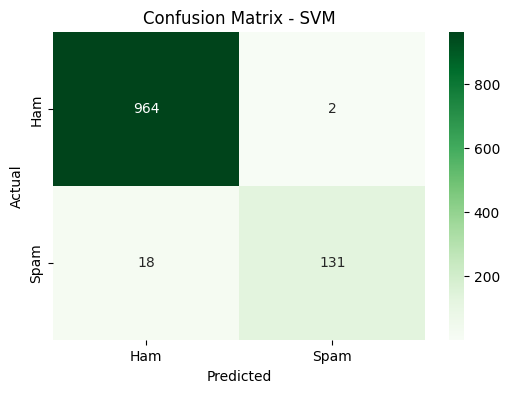

In [ ]:
print("\n--- Training Support Vector Machine (SVM) ---")
# Using a linear kernel often works well for text data
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()



--- Training Simple Neural Network (MLPClassifier) ---
MLPClassifier Performance:
Accuracy: 0.9821
Precision: 0.9640
Recall: 0.8993
F1-Score: 0.9306


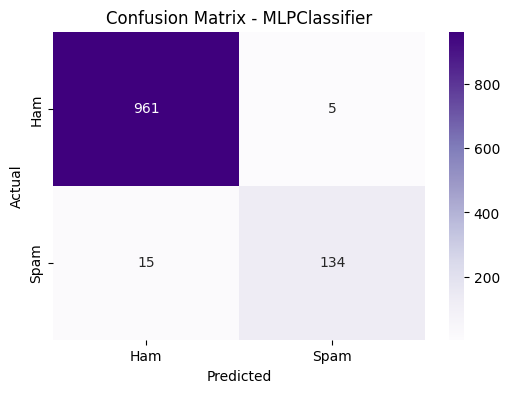

In [ ]:
print("\n--- Training Simple Neural Network (MLPClassifier) ---")
# hidden_layer_sizes: tuple, length i, ith element is the number of neurons in the ith hidden layer.
# max_iter: Maximum number of iterations to run.
# early_stopping: Whether to use early stopping to terminate training when validation score is not improving.
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', solver='adam', random_state=42, early_stopping=True, n_iter_no_change=10)
mlp_model.fit(X_train_tfidf, y_train)

y_pred_mlp = mlp_model.predict(X_test_tfidf)

print("MLPClassifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_mlp):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_mlp):.4f}")

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MLPClassifier')
plt.show()

In [ ]:
def predict_spam(message, vectorizer, model):
    # Preprocess the message
    processed_msg = preprocess_text(message)
    # Transform the message using the *fitted* TF-IDF vectorizer
    msg_tfidf = vectorizer.transform([processed_msg])
    # Make prediction
    prediction = model.predict(msg_tfidf)[0]
    return "SPAM" if prediction == 1 else "HAM"

# Example usage with the best performing model (e.g., SVM or Naive Bayes)
# Based on typical performance, Naive Bayes often performs very well for this dataset.
# Let's use the Multinomial Naive Bayes model for demonstration.
print("\n--- Testing with new messages (using Multinomial Naive Bayes) ---")

test_messages = [
    "Congratulations! You've won a free iPhone. Click here to claim your prize.",
    "Hey, how are you doing today? Let's catch up soon.",
    "URGENT! Your bank account has been compromised. Verify your details now: http://malicious.link",
    "Meeting reminder: Project review at 10 AM tomorrow.",
    "Free entry to exclusive club for only $100!"
]

for msg in test_messages:
    prediction = predict_spam(msg, tfidf_vectorizer, mnb_model)
    print(f"Message: '{msg}'\nPrediction: {prediction}\n")

print("\n--- Testing with new messages (using SVM) ---")
for msg in test_messages:
    prediction = predict_spam(msg, tfidf_vectorizer, svm_model)
    print(f"Message: '{msg}'\nPrediction: {prediction}\n")

print("\n--- Testing with new messages (using MLPClassifier) ---")
for msg in test_messages:
    prediction = predict_spam(msg, tfidf_vectorizer, mlp_model)
    print(f"Message: '{msg}'\nPrediction: {prediction}\n")



--- Testing with new messages (using Multinomial Naive Bayes) ---
Message: 'Congratulations! You've won a free iPhone. Click here to claim your prize.'
Prediction: SPAM

Message: 'Hey, how are you doing today? Let's catch up soon.'
Prediction: HAM

Message: 'URGENT! Your bank account has been compromised. Verify your details now: http://malicious.link'
Prediction: SPAM

Message: 'Meeting reminder: Project review at 10 AM tomorrow.'
Prediction: HAM

Message: 'Free entry to exclusive club for only $100!'
Prediction: SPAM


--- Testing with new messages (using SVM) ---
Message: 'Congratulations! You've won a free iPhone. Click here to claim your prize.'
Prediction: SPAM

Message: 'Hey, how are you doing today? Let's catch up soon.'
Prediction: HAM

Message: 'URGENT! Your bank account has been compromised. Verify your details now: http://malicious.link'
Prediction: SPAM

Message: 'Meeting reminder: Project review at 10 AM tomorrow.'
Prediction: HAM

Message: 'Free entry to exclusive club 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # For a simple neural network

# Download NLTK data (only needs to be run once)
# Moved nltk.download('punkt_tab') to Text Preprocessing section for guaranteed execution before use.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4') # Open Multilingual Wordnet for WordNetLemmatizer


# Load the dataset
# This dataset is commonly available and small enough to load directly.
# It's a tab-separated file with no header.
try:
    df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
    print("Dataset loaded from local file.")
except FileNotFoundError:
    # If not found locally, try downloading from a URL
    print("Local file not found. Attempting to download from URL...")
    # Use -nc (no-clobber) to avoid re-downloading if the file already exists
    # Updated URL to a working one for SMSSpamCollection.txt
    !wget -nc https://raw.githubusercontent.com/justmarkham/DAT5/master/data/SMSSpamCollection.txt -O SMSSpamCollection
    df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
    print("Dataset downloaded and loaded.")

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nValue counts for 'label':")
print(df['label'].value_counts())

# Map 'ham' to 0 and 'spam' to 1 for numerical processing
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})
print("\nFirst 5 rows with encoded label:")
print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Local file not found. Attempting to download from URL...
--2025-06-04 04:05:36--  https://raw.githubusercontent.com/justmarkham/DAT5/master/data/SMSSpamCollection.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 477907 (467K) [text/plain]
Saving to: ‘SMSSpamCollection’

SMSSpamCollection   100%[===================>] 466.71K  --.-KB/s    in 0.03s   

2025-06-04 04:05:36 (15.2 MB/s) - ‘SMSSpamCollection’ saved [477907/477907]

Dataset downloaded and loaded.

First 5 rows of the dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c 

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Original vs. Processed Message Examples:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Processed: go jurong point crazy available bugis n great world la e buffet cine got amore wat

Original: Ok lar... Joking wif u oni...
Processed: ok lar joking wif u oni

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Processed: free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply

Original: U dun say so early hor... U c already then say...
Processed: u dun say early hor u c already say

Original: Nah I don't think he goes to usf, he lives around here though
Processed: nah think go usf life around though



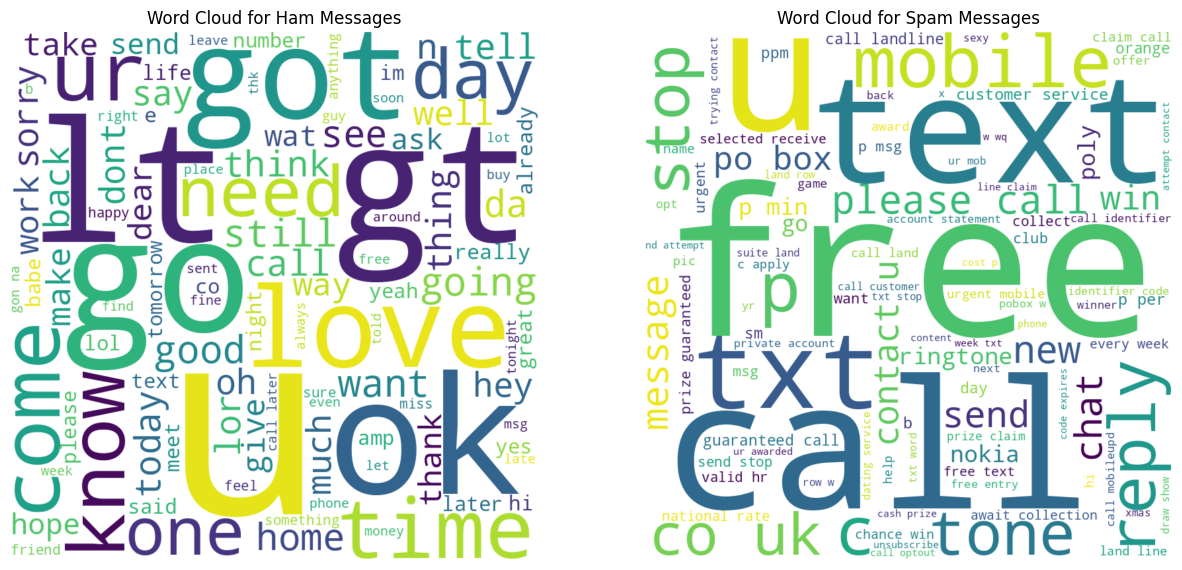

In [2]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Download punkt_tab here to ensure it's available before tokenization
nltk.download('punkt_tab')

def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()
    # 2. Remove punctuation and numbers
    # Keep only letters and spaces, replacing others with a space to avoid concatenating words
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 3. Tokenization
    words = nltk.word_tokenize(text)
    # 4. Remove stop words and Lemmatize
    # Corrected: 'not in' instead of 'not_in'
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # 5. Join words back into a string
    text = ' '.join(words)
    return text

# Apply preprocessing to the 'message' column
df['processed_message'] = df['message'].apply(preprocess_text)

print("\nOriginal vs. Processed Message Examples:")
for i in range(5):
    print(f"Original: {df['message'].iloc[i]}")
    print(f"Processed: {df['processed_message'].iloc[i]}\n")

# Visualize word clouds for ham and spam (optional but insightful)
from wordcloud import WordCloud

ham_words = ' '.join(list(df[df['label'] == 'ham']['processed_message']))
spam_words = ' '.join(list(df[df['label'] == 'spam']['processed_message']))

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
ham_wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate(ham_words)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate(spam_words)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')

plt.show()

In [3]:
# Split data into training and testing sets
X = df['processed_message']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} messages")
print(f"Testing set size: {X_test.shape[0]} messages")
print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Testing label distribution:\n{y_test.value_counts()}")

# Initialize TF-IDF Vectorizer
# max_features limits the number of features to the most frequent ones
# min_df ignores terms that appear in too few documents
# max_df ignores terms that appear in too many documents (e.g., common words not caught by stop words)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)

# Fit the vectorizer on the training data and transform both training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nShape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")


Training set size: 4457 messages
Testing set size: 1115 messages
Training label distribution:
label_encoded
0    3859
1     598
Name: count, dtype: int64
Testing label distribution:
label_encoded
0    966
1    149
Name: count, dtype: int64

Shape of X_train_tfidf: (4457, 1339)
Shape of X_test_tfidf: (1115, 1339)



--- Training Multinomial Naive Bayes ---
Multinomial Naive Bayes Performance:
Accuracy: 0.9740
Precision: 0.9688
Recall: 0.8322
F1-Score: 0.8953


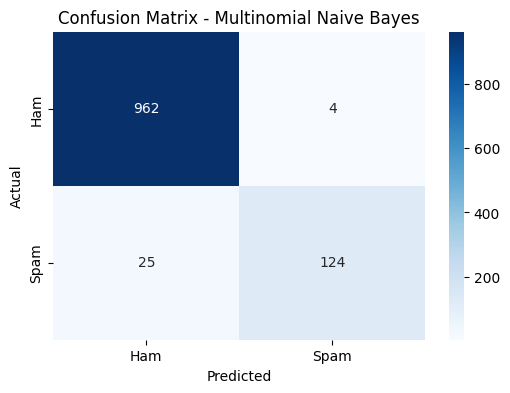

In [4]:
print("\n--- Training Multinomial Naive Bayes ---")
mnb_model = MultinomialNB()
mnb_model.fit(X_train_tfidf, y_train)

y_pred_mnb = mnb_model.predict(X_test_tfidf)

print("Multinomial Naive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mnb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_mnb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_mnb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_mnb):.4f}")

# Confusion Matrix
cm_mnb = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.show()



--- Training Support Vector Machine (SVM) ---
SVM Performance:
Accuracy: 0.9821
Precision: 0.9850
Recall: 0.8792
F1-Score: 0.9291


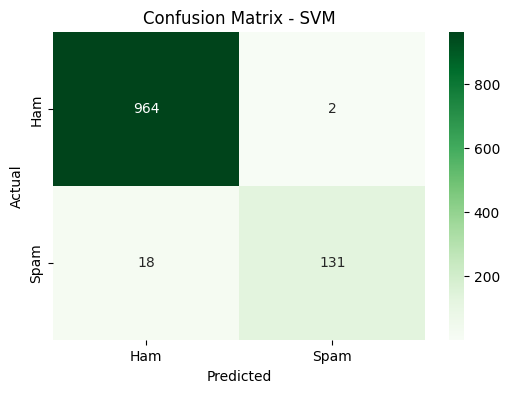

In [5]:
print("\n--- Training Support Vector Machine (SVM) ---")
# Using a linear kernel often works well for text data
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()



--- Training Simple Neural Network (MLPClassifier) ---
MLPClassifier Performance:
Accuracy: 0.9821
Precision: 0.9640
Recall: 0.8993
F1-Score: 0.9306


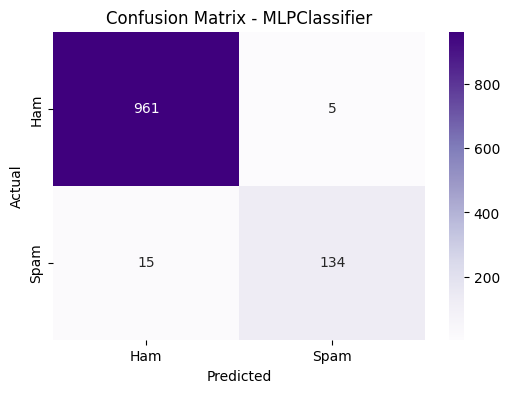

In [6]:
print("\n--- Training Simple Neural Network (MLPClassifier) ---")
# hidden_layer_sizes: tuple, length i, ith element is the number of neurons in the ith hidden layer.
# max_iter: Maximum number of iterations to run.
# early_stopping: Whether to use early stopping to terminate training when validation score is not improving.
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', solver='adam', random_state=42, early_stopping=True, n_iter_no_change=10)
mlp_model.fit(X_train_tfidf, y_train)

y_pred_mlp = mlp_model.predict(X_test_tfidf)

print("MLPClassifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_mlp):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_mlp):.4f}")

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MLPClassifier')
plt.show()


In [7]:
import joblib # For saving and loading models

# --- Save the trained models and TF-IDF vectorizer ---
print("\n--- Saving Trained Models and TF-IDF Vectorizer ---")
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(mnb_model, 'mnb_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(mlp_model, 'mlp_model.pkl')
print("Models and vectorizer saved successfully as .pkl files.")

# --- Load the trained models and TF-IDF vectorizer (demonstration) ---
# In a real application, you would load these in a separate script or session
# without retraining the entire model.
print("\n--- Loading Trained Models and TF-IDF Vectorizer ---")
loaded_tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
loaded_mnb_model = joblib.load('mnb_model.pkl')
loaded_svm_model = joblib.load('svm_model.pkl')
loaded_mlp_model = joblib.load('mlp_model.pkl')
print("Models and vectorizer loaded successfully.")


# --- Function for prediction (using loaded models) ---
def predict_spam_loaded(message, vectorizer, model):
    # Preprocess the message using the same function as during training
    processed_msg = preprocess_text(message)
    # Transform the message using the *loaded* TF-IDF vectorizer
    msg_tfidf = vectorizer.transform([processed_msg])
    # Make prediction
    prediction = model.predict(msg_tfidf)[0]
    return "SPAM" if prediction == 1 else "HAM"

# --- Advanced Test Cases and Batch Prediction ---
print("\n--- Advanced Testing with New Messages (using Loaded Multinomial Naive Bayes) ---")

# A larger, more diverse set of test messages
advanced_test_messages = [
    "Congratulations! You've won a free iPhone. Text WIN to 12345 to claim your prize. Limited time offer!",
    "Hi John, just wanted to confirm our meeting for tomorrow at 3 PM. See you then!",
    "URGENT: Your account has been suspended. Click this link immediately to reactivate: http://bit.ly/maliciouslink",
    "Hey, are you free for a quick call later today? Let me know.",
    "Claim your FREE lottery prize of $1,000,000! Reply YES to 88888 now!",
    "Your Amazon order #12345 is on its way. Track here: https://amazon.com/track/12345",
    "Get rich quick! Invest in our new crypto scheme. Guaranteed returns!",
    "Reminder: Don't forget to submit your report by end of day.",
    "Exclusive offer for you! 50% off all products this week only. Shop now!",
    "Hello, how are you doing? Hope you have a great day!",
    "You have been selected for a special vacation package. Call 1-800-SPAM-NOW for details.",
    "Please find the attached invoice for your recent purchase."
]

# Perform batch predictions using the loaded MNB model
print("\n--- Batch Predictions with Loaded Multinomial Naive Bayes ---")
for msg in advanced_test_messages:
    prediction = predict_spam_loaded(msg, loaded_tfidf_vectorizer, loaded_mnb_model)
    print(f"Message: '{msg}'\nPrediction: {prediction}\n")

# You can repeat this for other loaded models (SVM, MLP)
print("\n--- Batch Predictions with Loaded SVM Model ---")
for msg in advanced_test_messages:
    prediction = predict_spam_loaded(msg, loaded_tfidf_vectorizer, loaded_svm_model)
    print(f"Message: '{msg}'\nPrediction: {prediction}\n")

print("\n--- Batch Predictions with Loaded MLPClassifier Model ---")
for msg in advanced_test_messages:
    prediction = predict_spam_loaded(msg, loaded_tfidf_vectorizer, loaded_mlp_model)
    print(f"Message: '{msg}'\nPrediction: {prediction}\n")

# --- Further testing ideas ---
print("\n--- Further Testing Ideas ---")
print("1. Create a separate, unseen dataset of messages (ham and spam).")
print("2. Load this new dataset and apply the `preprocess_text` function.")
print("3. Use `loaded_tfidf_vectorizer.transform()` on the new dataset.")
print("4. Use `loaded_mnb_model.predict()` (or other models) on the transformed data.")
print("5. Evaluate the model's performance (accuracy, precision, recall, F1-score) on this entirely new dataset.")
print("This simulates real-world performance on future, un-trained data.")



--- Saving Trained Models and TF-IDF Vectorizer ---
Models and vectorizer saved successfully as .pkl files.

--- Loading Trained Models and TF-IDF Vectorizer ---
Models and vectorizer loaded successfully.

--- Advanced Testing with New Messages (using Loaded Multinomial Naive Bayes) ---

--- Batch Predictions with Loaded Multinomial Naive Bayes ---
Message: 'Congratulations! You've won a free iPhone. Text WIN to 12345 to claim your prize. Limited time offer!'
Prediction: SPAM

Message: 'Hi John, just wanted to confirm our meeting for tomorrow at 3 PM. See you then!'
Prediction: HAM

Message: 'URGENT: Your account has been suspended. Click this link immediately to reactivate: http://bit.ly/maliciouslink'
Prediction: SPAM

Message: 'Hey, are you free for a quick call later today? Let me know.'
Prediction: HAM

Message: 'Claim your FREE lottery prize of $1,000,000! Reply YES to 88888 now!'
Prediction: SPAM

Message: 'Your Amazon order #12345 is on its way. Track here: https://amazon.com/